In [1]:
!nvidia-smi

Tue May  8 15:31:07 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 387.34                 Driver Version: 387.34                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 31%   51C    P8    20W / 250W |  10348MiB / 11167MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 34%   54C    P8    19W / 250W |   3191MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
from samplers.full_stack_batcher import FullStackBatcher as Batcher
from nets.low_net3D_1 import Net
from tensorboardX import SummaryWriter

import torch
import os
import numpy as np
import gc

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
data_dir = '../../data/'
man = '40'
num_train_frames = 210
num_val_frames = 30
num_test_frames = 60

In [5]:
train_batcher = Batcher(data_dir, man, 0, 540 * (num_train_frames - 1), segment_length=1024*4)
val_batcher = Batcher(data_dir, man, 540 * (num_train_frames + 1), 540 * (num_train_frames + num_val_frames - 1), segment_length=1024*4)
test_batcher = Batcher(data_dir, man, 540 * (num_train_frames + num_val_frames + 1), 540 * (num_train_frames + num_val_frames + num_test_frames - 1), segment_length=1024*4)

Extracting parameters from ../../data/EEG/40/export/20130510400002_Pulse_Artifact_Correction_bin.vhdr...
No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
Setting channel info structure...
Currently, 4 trigger(s) will be dropped, such as [Sync On, s , R, Scanner start]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.


/home/amplifier/home/proj_dev/eeg2fmri/samplers/full_stack_batcher.py:43: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  eeg = mne.io.read_raw_brainvision(path, event_id={"Scan Start": 1})
/home/amplifier/home/proj_dev/eeg2fmri/samplers/full_stack_batcher.py:43: RuntimeWarning: Currently, 4 trigger(s) will be dropped, such as [Sync On, s , R, Scanner start]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
  eeg = mne.io.read_raw_brainvision(path, event_id={"Scan Start": 1})


300 events found
Events id: [1]
Extracting parameters from ../../data/EEG/40/export/20130510400002_Pulse_Artifact_Correction_bin.vhdr...
No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
Setting channel info structure...
Currently, 4 trigger(s) will be dropped, such as [Sync On, s , R, Scanner start]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.


/home/amplifier/home/proj_dev/eeg2fmri/samplers/full_stack_batcher.py:43: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  eeg = mne.io.read_raw_brainvision(path, event_id={"Scan Start": 1})
/home/amplifier/home/proj_dev/eeg2fmri/samplers/full_stack_batcher.py:43: RuntimeWarning: Currently, 4 trigger(s) will be dropped, such as [Sync On, s , R, Scanner start]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
  eeg = mne.io.read_raw_brainvision(path, event_id={"Scan Start": 1})


300 events found
Events id: [1]
Extracting parameters from ../../data/EEG/40/export/20130510400002_Pulse_Artifact_Correction_bin.vhdr...
No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
Setting channel info structure...
Currently, 4 trigger(s) will be dropped, such as [Sync On, s , R, Scanner start]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.


/home/amplifier/home/proj_dev/eeg2fmri/samplers/full_stack_batcher.py:43: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  eeg = mne.io.read_raw_brainvision(path, event_id={"Scan Start": 1})
/home/amplifier/home/proj_dev/eeg2fmri/samplers/full_stack_batcher.py:43: RuntimeWarning: Currently, 4 trigger(s) will be dropped, such as [Sync On, s , R, Scanner start]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
  eeg = mne.io.read_raw_brainvision(path, event_id={"Scan Start": 1})


300 events found
Events id: [1]


In [6]:
net = Net().cuda()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
fmri_mult = 100

In [7]:
!rm -r reports/low_net3D_1

In [8]:
report_path = 'reports/low_net3D_1'
logs_directory = os.path.join(report_path, 'logs')
iteration = 0
history = []
val_history = []
history_step = 250
batch_size = 1
batch_size_iters=100*50
max_batch_size=128
num_iters = 50*500
writer = SummaryWriter(logs_directory)

In [ ]:
num_iters = 500*50

In [ ]:
while iteration < num_iters:
    iteration += 1
    X, y = train_batcher.get_batch(batch_size)
    X = torch.autograd.Variable(X.data.cuda())
    y = y.cuda() * fmri_mult
    res = net(X)
    optimizer.zero_grad()
    train_loss = loss(res, y)
    train_loss.backward()
    optimizer.step()

    if iteration % history_step == 0:
        e, f = val_batcher.get_batch(batch_size)
        e = torch.autograd.Variable(e.data.cuda(), requires_grad=True)
        f = f.cuda() * fmri_mult
        res = net(e)
        val_loss = loss(res, f)
        val_loss.backward()
        
        res = res.data.cpu().numpy()
        f = f.data.cpu().numpy()
        grad = e.grad.data.cpu().numpy()
        
        writer.add_scalars('learning_stats/progress',
                       {
                           "train loss": train_loss,
                           'validation loss':val_loss,
                       },
                       iteration)
        
        for slice_index in range(30):
            val_output = res[0, slice_index]
            val_gt = f[0, slice_index]
            saving_example = np.concatenate([val_output, val_gt], axis=1)
            saving_example /= saving_example.max()
            saving_example = saving_example[..., np.newaxis]
            saving_example = np.concatenate([saving_example, saving_example, saving_example], -1)
            writer.add_image('ValidationExamples/slice_{}'.format(slice_index), saving_example, iteration)
        
        grad_stats_max = np.max(np.abs(grad).mean(0))
        for eeg_channel_index in range(64):
            grad_stats = np.abs(grad[:, eeg_channel_index]).mean(0) / grad_stats_max
            grad_stats = grad_stats[..., np.newaxis]
            grad_stats = np.concatenate([grad_stats, grad_stats, grad_stats], -1)
            writer.add_image('GradStatisics/channel_{}'.format(eeg_channel_index), grad_stats, iteration)
        

    if iteration % batch_size_iters == 0:
        batch_size *= 2
        batch_size = min(batch_size, max_batch_size)
        gc.collect()




In [11]:
iteration

30001

In [12]:
batch_size

64

In [21]:
from matplotlib import pyplot as plt

In [ ]:
plt.imshow(np.abs(grad[:, 16]).mean(0))
plt.show()

In [ ]:
!ls ../../reports/500_50_iters_1_non_const_bs/49

In [ ]:
lol = np.load('../../reports/500_50_iters_1_non_const_bs/49/val_history.npy') 

In [ ]:
lol[-1]

In [ ]:
!nvidia-smi

In [15]:
torch.save(net, os.path.join(report_path, 'models', 'net'))

In [14]:
os.makedirs(os.path.join(report_path, 'models'))

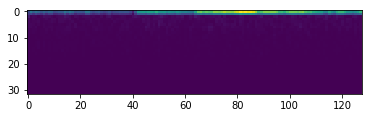

In [23]:
plt.imshow(e.data.cpu().numpy()[0, 16])
plt.show()